In [1]:
# Gerekli Kütüphaneleri Yükleyin
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Gereksiz uyarıları bastır
warnings.filterwarnings('ignore', category=UserWarning, module='xgboost')

In [2]:
data= pd.read_csv(r"C:\Users\hsynt\Downloads\Selcuk Abi\Selcuk Abi\VeriSeti2.csv")

Holdout Results:
            Accuracy  Precision    Recall  F1-Score   AUC-ROC
No PCA/LDA  0.851911   0.861789  0.879746  0.870675  0.922432
With PCA    0.797278   0.811440  0.836659  0.823857  0.879485
With LDA    0.820292   0.832960  0.854141  0.843418  0.885928


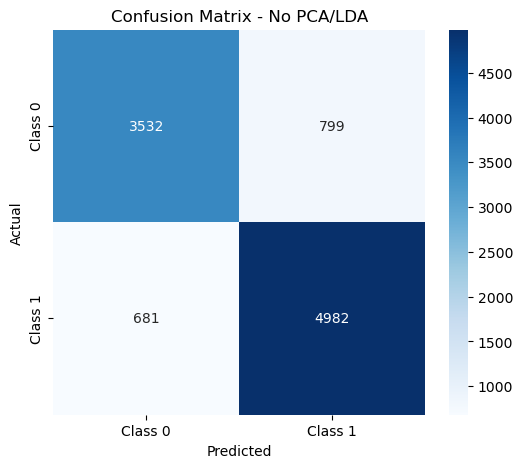

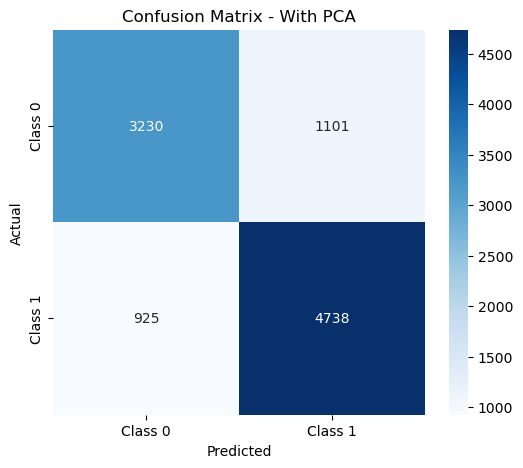

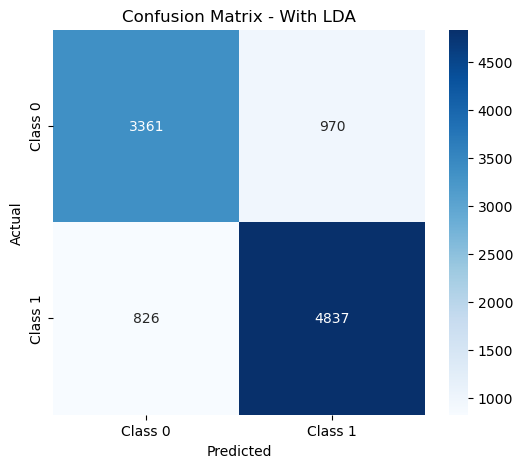


K-Fold Results:
   Accuracy  Precision    Recall  F1-Score   AUC-ROC    Model  \
0  0.835122   0.840454  0.874469  0.857124  0.912138  XGBoost   
1  0.837448   0.839509  0.880956  0.859733  0.910630  XGBoost   
2  0.839313   0.848897  0.872972  0.860766  0.912899  XGBoost   
3  0.801126   0.811687  0.844214  0.827631  0.877299  XGBoost   
4  0.794972   0.802570  0.845388  0.823423  0.873002  XGBoost   
5  0.801711   0.817376  0.838939  0.828017  0.876099  XGBoost   
6  0.819362   0.827983  0.859076  0.843243  0.886702  XGBoost   
7  0.815159   0.816052  0.869011  0.841699  0.883284  XGBoost   
8  0.821225   0.832459  0.858594  0.845325  0.887170  XGBoost   

             Reduction  
0  No PCA/LDA (Fold 1)  
1  No PCA/LDA (Fold 2)  
2  No PCA/LDA (Fold 3)  
3         PCA (Fold 1)  
4         PCA (Fold 2)  
5         PCA (Fold 3)  
6         LDA (Fold 1)  
7         LDA (Fold 2)  
8         LDA (Fold 3)  


In [3]:

# Özellik ve Hedef Ayrımı
X = data.drop(columns=['Target_10', 'adjclose'])
y = data['Target_10']

# Ek Özellikler: Momentum ve Trend Göstergeleri
data['Momentum_5'] = data['adjclose'] - data['adjclose'].shift(5)
data['Momentum_10'] = data['adjclose'] - data['adjclose'].shift(10)
data['Trend'] = (data['adjclose'] - data['MA_20']) / data['MA_20']

# Özellik Güncellemesi
X['Momentum_5'] = data['Momentum_5']
X['Momentum_10'] = data['Momentum_10']
X['Trend'] = data['Trend']

# Eksik Değerleri Doldurma
X.fillna(0, inplace=True)

# Eğitim ve Test Setlerine Bölme
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Özellikleri Ölçeklendirme
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# PCA ve LDA Dönüşümleri
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

lda = LDA()
X_train_lda = lda.fit_transform(X_train_scaled, y_train)
X_test_lda = lda.transform(X_test_scaled)

# XGBoost Modeli
xgb_clf = XGBClassifier(
    random_state=42,
    n_estimators=6000,
    learning_rate=0.001,
    max_depth=20,
    subsample=0.9,
    colsample_bytree=0.9,
    gamma=0.002,
    min_child_weight=1
)

# Performans Metriklerini Hesaplama
def calculate_metrics(y_true, y_pred, y_pred_proba):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-Score": f1_score(y_true, y_pred),
        "AUC-ROC": roc_auc_score(y_true, y_pred_proba)
    }

# Holdout Sonuçları
xgb_clf.fit(X_train_scaled, y_train)
y_pred_no_reduction = xgb_clf.predict(X_test_scaled)
y_pred_proba_no_reduction = xgb_clf.predict_proba(X_test_scaled)[:, 1]

xgb_clf.fit(X_train_pca, y_train)
y_pred_pca = xgb_clf.predict(X_test_pca)
y_pred_proba_pca = xgb_clf.predict_proba(X_test_pca)[:, 1]

xgb_clf.fit(X_train_lda, y_train)
y_pred_lda = xgb_clf.predict(X_test_lda)
y_pred_proba_lda = xgb_clf.predict_proba(X_test_lda)[:, 1]

# Holdout Metrikleri
holdout_results = {
    "No PCA/LDA": calculate_metrics(y_test, y_pred_no_reduction, y_pred_proba_no_reduction),
    "With PCA": calculate_metrics(y_test, y_pred_pca, y_pred_proba_pca),
    "With LDA": calculate_metrics(y_test, y_pred_lda, y_pred_proba_lda)
}

holdout_df = pd.DataFrame(holdout_results).T
print("Holdout Results:")
print(holdout_df)

# Karışıklık Matrislerini Görselleştirme
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

plot_confusion_matrix(y_test, y_pred_no_reduction, "Confusion Matrix - No PCA/LDA")
plot_confusion_matrix(y_test, y_pred_pca, "Confusion Matrix - With PCA")
plot_confusion_matrix(y_test, y_pred_lda, "Confusion Matrix - With LDA")

# K-Fold Çapraz Doğrulama
kf = KFold(n_splits=3)

# K-Fold Sonuçlarını Hesaplama
kfold_results = []

# No PCA/LDA
for fold, (train_index, test_index) in enumerate(kf.split(X_train_scaled)):
    X_fold_train, X_fold_test = X_train_scaled[train_index], X_train_scaled[test_index]
    y_fold_train, y_fold_test = y_train.iloc[train_index], y_train.iloc[test_index]

    xgb_clf.fit(X_fold_train, y_fold_train)
    y_fold_pred = xgb_clf.predict(X_fold_test)
    y_fold_pred_proba = xgb_clf.predict_proba(X_fold_test)[:, 1]

    metrics = calculate_metrics(y_fold_test, y_fold_pred, y_fold_pred_proba)
    metrics['Model'] = 'XGBoost'
    metrics['Reduction'] = f'No PCA/LDA (Fold {fold + 1})'
    kfold_results.append(metrics)

# PCA
for fold, (train_index, test_index) in enumerate(kf.split(X_train_pca)):
    X_fold_train, X_fold_test = X_train_pca[train_index], X_train_pca[test_index]
    y_fold_train, y_fold_test = y_train.iloc[train_index], y_train.iloc[test_index]

    xgb_clf.fit(X_fold_train, y_fold_train)
    y_fold_pred = xgb_clf.predict(X_fold_test)
    y_fold_pred_proba = xgb_clf.predict_proba(X_fold_test)[:, 1]

    metrics = calculate_metrics(y_fold_test, y_fold_pred, y_fold_pred_proba)
    metrics['Model'] = 'XGBoost'
    metrics['Reduction'] = f'PCA (Fold {fold + 1})'
    kfold_results.append(metrics)

# LDA
for fold, (train_index, test_index) in enumerate(kf.split(X_train_lda)):
    X_fold_train, X_fold_test = X_train_lda[train_index], X_train_lda[test_index]
    y_fold_train, y_fold_test = y_train.iloc[train_index], y_train.iloc[test_index]

    xgb_clf.fit(X_fold_train, y_fold_train)
    y_fold_pred = xgb_clf.predict(X_fold_test)
    y_fold_pred_proba = xgb_clf.predict_proba(X_fold_test)[:, 1]

    metrics = calculate_metrics(y_fold_test, y_fold_pred, y_fold_pred_proba)
    metrics['Model'] = 'XGBoost'
    metrics['Reduction'] = f'LDA (Fold {fold + 1})'
    kfold_results.append(metrics)

# Sonuçları DataFrame olarak göster
kfold_df = pd.DataFrame(kfold_results)
print("\nK-Fold Results:")
print(kfold_df)